# Tutorial 3.1: Getting started with GANs

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under_Construction&color=orange)


**Open notebook on:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial3_1_gan_getting_started/tutorial3_1_gan_getting_started.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial3_1_gan_getting_started/tutorial3_1_gan_getting_started.ipynb)   
**Author:** Christoph R. Landolt


In tutorial 2.2, we explored the Variational Autoencoder (VAE), a type of generative model. Another, fundamentally different architecture used for data generation is the Generative Adversarial Network (GAN), which consists of two competing neural networks, each with its own objective.

A **Generator** network creates new samples, aiming to produce data indistinguishable from real data. A **Discriminator** network aims to correctly classify samples as either real or synthetically generated by the Generator. This setup creates a competitive, adversarial dynamic.

This adversarial training setup has **dual-use applications** in cybersecurity: it can be used to train highly sophisticated detector networks for Intrusion Detection Systems (IDS), or, conversely, to train 'smart' generators capable of creating evasive attack samples that bypass machine learning-driven IDSs. In this tutorial, we will learn how to implement and train a simple GAN in PyTorch.

## Tutorial Objectives
By the end of this tutorial, you will be able to:
- Explain the core architecture and **adversarial objective** of a Generative Adversarial Network (GAN).
- Implement the Generator and Discriminator neural networks in PyTorch.
- Train a simple GAN to generate synthetic data.

## Game Theory and Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) represent a game between two neural networks trained in an adversarial manner to reach a **zero-sum Nash equilibrium profile**. In this setup, the Generator and Discriminator are engaged in a competitive **minimax game**, striving to outmaneuver each other.

### Basics of GANs in Terms of Game Theory

GANs can be understood as a zero-sum, two-player minimax game, where the two players are the **Generator** $G(z)$ and the **Discriminator** $D(x)$.

<img src="./vanilla_GAN_Architecture.jpg" alt="vanilla_GAN_Architecture" width="600"/>


#### Players

- **Generator $G(z; \theta_G)$:**
    The generator takes a random noise vector $z$, sampled from a prior noise distribution $p_z(z)$ (usually uniform or Gaussian), and maps it to approximate the training data distribution $p_g(x)$. The goal of $G$ is to generate samples indistinguishable from the real data distribution $p_{\text{data}}(x)$.

- **Discriminator $D(x; \theta_D)$:**
    The discriminator takes an input $x$ (either a real sample from $p_{\text{data}}(x)$ or a fake sample from the generator $G$) and outputs a probability $D(x)$ in the range $[0, 1]$, representing its confidence that $x$ is a real sample.

#### Objective

The GAN framework’s objective is to find the Nash equilibrium of the following **minimax game**:

$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

Different choices for the functions $\log D(x)$ and $\log(1 - D(G(z)))$ lead to variations in GAN objectives and metrics (e.g., WGAN, LSGAN).
<table class="tutorial-table" border="1" style="width:100%; border-collapse: collapse;">
    <thead>
        <tr>
            <th>Variant</th>
            <th>f0(D)</th>
            <th>f1(D)</th>
            <th>Divergence Metric</th>
            <th>Game Value</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>Vanilla GAN</b></td>
            <td>log D</td>
            <td>log(1 - D)</td>
            <td>Jensen-Shannon Divergence (JSD)</td>
            <td>- log 4</td>
            <td>The original GAN formulation by Goodfellow et al. (2014).</td>
        </tr>
        <tr>
            <td><b>Wasserstein GAN (WGAN)</b></td>
            <td>D</td>
            <td>-D</td>
            <td>Wasserstein-1 Distance (Earth Mover's)</td>
            <td>0</td>
            <td>WGAN uses the Earth Mover's distance (Wasserstein-1) as a metric, providing better gradients.</td>
        </tr>
        <tr>
            <td><b>Hinge GAN</b></td>
            <td>min(0, -1 + D)</td>
            <td>min(0, -1 - D)</td>
            <td>Hinge Loss</td>
            <td>0</td>
            <td>Hinge loss encourages the discriminator to correctly classify real and fake samples with a margin.</td>
        </tr>
        <tr>
            <td><b>f-GAN (KL)</b></td>
            <td>log D</td>
            <td>1 - D</td>
            <td>Kullback-Leibler (KL) Divergence</td>
            <td>0</td>
            <td>f-GAN with KL divergence as the f-divergence.</td>
        </tr>
        <tr>
            <td><b>f-GAN (Reverse KL)</b></td>
            <td>-D</td>
            <td>log D</td>
            <td>Reverse Kullback-Leibler (Reverse KL)</td>
            <td>-1</td>
            <td>f-GAN with Reverse KL divergence as the f-divergence.</td>
        </tr>
    </tbody>
</table>

The original formulation by [Goodfellow et al.](https://arxiv.org/abs/1406.2661) uses **cross-entropy loss** for adversarial dynamics.

*   [**Wasserstein GAN (WGAN):**](https://arxiv.org/abs/1701.07875) Uses the **Earth Mover’s distance** for stable gradient flow and improved convergence.
*   **Hinge GAN:** Uses the **Hinge Loss** and encourages a margin between correct and incorrect classifications.

### Detailed Objectives

#### Discriminator’s Objective

The discriminator $D$ seeks to **maximize** its ability to distinguish real samples ($x$) from fake samples ($G(z)$):

$$
\max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

#### Generator’s Objective

The generator $G$ seeks to **minimize** the discriminator’s ability to correctly classify fake samples as generated:

$$
\min_G V(D, G) = \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

### Minimax Game Interpretation

The GAN framework models a **zero-sum game** where the generator $G$ and the discriminator $D$ compete.

*   The generator $G$ aims to create samples that are indistinguishable from real data.
*   The discriminator $D$ aims to accurately classify samples as real or generated.

The **Nash equilibrium** is reached when $p_g = p_{\text{data}}$ and the discriminator is unable to distinguish the two distributions, resulting in:

$$
D^*(x)=0.5 \quad \text{for all } x
$$

#### Optimality

The optimal discriminator $D^*$ and generator $G^*$ satisfy:

$$
D^*(x) = \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_g(x)}
$$

and

$$
p_g = p_{\text{data}}
$$

At this point, the generator perfectly replicates the real data distribution, and the discriminator cannot distinguish between real and generated samples. This game-theoretic foundation not only explains the dynamics of GANs but also highlights their flexibility for various tasks, from image synthesis to adversarial data generation.

## 2. Implementation of a Simple Vanilla GAN in PyTorch
We will implement a simple **Vanilla GAN** to generate 2D data points that follow a multimodal Gaussian distribution (two distinct clusters).

#### Step 1: Define Network Architectures and Data Functions

We define the Generator and Discriminator as simple Multi-Layer Perceptrons (MLPs). The `generate_real_data` function simulates a real-world dataset with two distinct clusters.

In [47]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Input dimension is 10 (noise), output dimension is 2 (for 2D data)
        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.fc(x)

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Input dimension is 2 (for 2D data), output dimension is 1 (binary classification)
        self.fc = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Sigmoid()        # Sigmoid activation to output probabilities
        )

    def forward(self, x):
        return self.fc(x)

# Toy dataset with multimodal Gaussian distribution (two clusters)
def generate_real_data(batch_size=64, mean1=0.0, mean2=10.0, std=1.0):
    # Half of the samples from mean1
    half_batch = batch_size // 2
    data1 = np.random.normal(mean1, std, (half_batch, 2))

    # Half of the samples from mean2
    data2 = np.random.normal(mean2, std, (batch_size - half_batch, 2))

    # Combine both parts
    combined_data = np.vstack([data1, data2])

    # Convert to torch tensor
    return torch.tensor(combined_data, dtype=torch.float32)

# Function to generate noise vector for the Generator
def generate_noise(batch_size=64, noise_dim=10):
    return torch.tensor(np.random.randn(batch_size, noise_dim), dtype=torch.float32)

#### Step 2: Initialization and Training Setup
We initialize the models, the Binary Cross-Entropy (BCE) loss function, and the Adam optimizers for both the Generator ($G$) and the Discriminator ($D$).

In [48]:
# Initialization
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss() # Standard loss for Vanilla GAN
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# Training parameters
num_epochs = 10000
batch_size = 64
noise_dim = 10

losses_d = []
losses_g = []

#### Step 3: The Adversarial Training Loop
he core of the GAN training involves alternating updates: first, updating the Discriminator ($D$) to correctly classify real and fake samples, and second, updating the Generator ($G$) to fool the Discriminator.

In [49]:
# Training loop
for epoch in range(num_epochs):
    # --- 1. Train Discriminator ---
    optimizer_d.zero_grad()

    # Generate real and fake data
    real_data = generate_real_data(batch_size)
    # Detach fake data to prevent gradients from flowing back to the Generator
    fake_data = generator(generate_noise(batch_size, noise_dim)).detach()

    # D Loss on REAL data (target: 1)
    real_labels = torch.ones(batch_size, 1)
    output_real = discriminator(real_data)
    loss_d_real = criterion(output_real, real_labels)

    # D Loss on FAKE data (target: 0)
    fake_labels = torch.zeros(batch_size, 1)
    output_fake = discriminator(fake_data)
    loss_d_fake = criterion(output_fake, fake_labels)

    # Total loss and update Discriminator
    loss_d = loss_d_real + loss_d_fake
    loss_d.backward()
    optimizer_d.step()

    # --- 2. Train Generator ---
    optimizer_g.zero_grad()

    # Generate new fake data (not detached)
    fake_data = generator(generate_noise(batch_size, noise_dim))

    # G Loss (target: 1 -> Generator tries to fool D into thinking fake data is real)
    real_labels = torch.ones(batch_size, 1)
    output_fake = discriminator(fake_data)
    loss_g = criterion(output_fake, real_labels)

    # Update Generator
    loss_g.backward()
    optimizer_g.step()

    # Save losses and print progress
    losses_d.append(loss_d.item())
    losses_g.append(loss_g.item())

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')

Epoch [0/10000], Loss D: 1.2968, Loss G: 0.6921
Epoch [1000/10000], Loss D: 1.0259, Loss G: 1.0188
Epoch [2000/10000], Loss D: 1.1326, Loss G: 0.9894
Epoch [3000/10000], Loss D: 1.2661, Loss G: 0.9625
Epoch [4000/10000], Loss D: 1.0694, Loss G: 0.8701
Epoch [5000/10000], Loss D: 1.1099, Loss G: 1.1393
Epoch [6000/10000], Loss D: 0.9998, Loss G: 0.9766
Epoch [7000/10000], Loss D: 1.0572, Loss G: 1.0982
Epoch [8000/10000], Loss D: 0.9741, Loss G: 1.0837
Epoch [9000/10000], Loss D: 0.9720, Loss G: 1.0960


#### Step 4: Visualization and Evaluation
We visualize the training progress by plotting the Generator and Discriminator losses and then compare the generated data against the real data distribution.

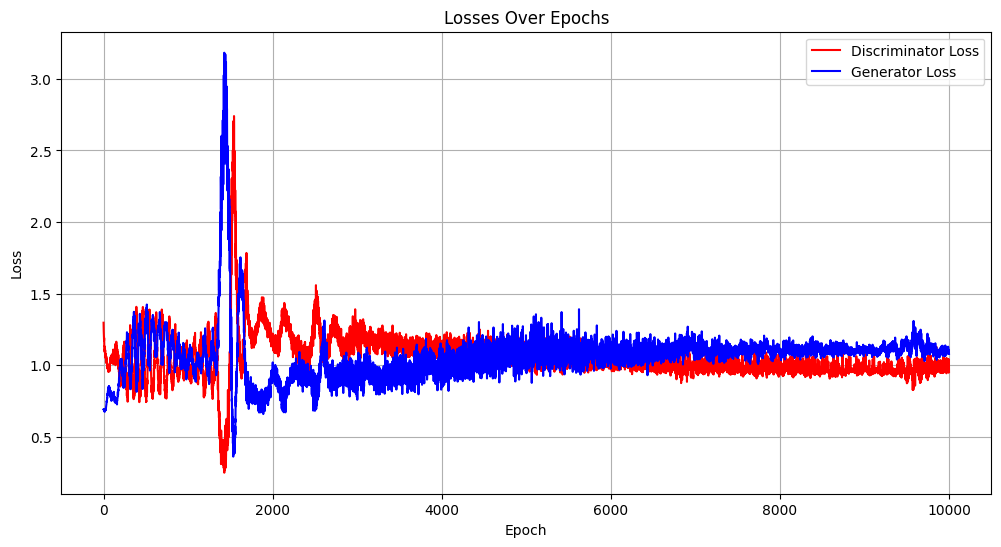

In [50]:
# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(losses_d, label='Discriminator Loss', color='red')
plt.plot(losses_g, label='Generator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Note: Interpreting Oscillating Losses**

The Generator and Discriminator losses in the plot are **oscillating** rather than smoothly decreasing. This instability is typical for GANs because training seeks a dynamic **Nash equilibrium** where neither network can unilaterally improve. This characteristic makes the training of GANs **unstable** and **challenging**.

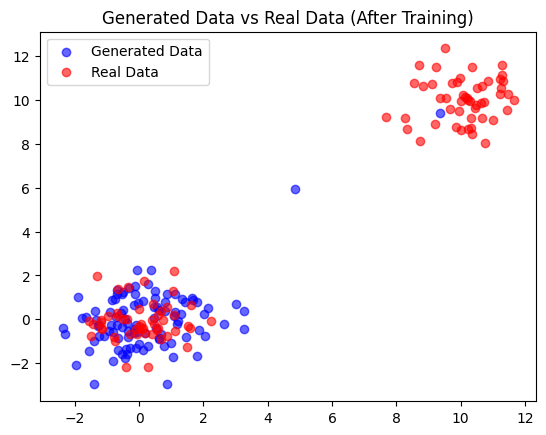

In [51]:
# Plot results
with torch.no_grad():
    noise = generate_noise(100, noise_dim)
    generated_data = generator(noise).numpy()

# Note: generate_real_data() is called again to get fresh real data for the plot
plt.scatter(generated_data[:, 0], generated_data[:, 1], c='blue', label='Generated Data', alpha=0.6)
plt.scatter(generate_real_data(100).numpy()[:, 0], generate_real_data(100).numpy()[:, 1], c='red', label='Real Data', alpha=0.6)
plt.legend()
plt.title('Generated Data vs Real Data (After Training)')
plt.show()

## Advanced GAN Training: Multi-Agent Diverse GAN (MAD-GAN) Setup

While the Vanilla GAN provides a strong foundation, its training is often unstable and prone to **mode collapse** (where the generator only learns to produce a small subset of the data distribution). Game theory offers solutions to these issues by adapting the adversarial dynamics. In this section, we implement a **Multi-Agent GAN (MAD-GAN)** setup using two competing generators to visualize how multi-generator dynamics can increase training stability and improve output diversity.

#### Conceptual Advancements

Game theory provides a natural framework for analyzing and improving the training and performance of GANs, tackling challenges such as instability, non-convergence, and **mode collapse**.

- **Multi-Agent Games:** MAD-GANs leverage game-theoretic principles to employ multiple generators and a single discriminator. By having multiple generators compete to cover the data distribution, the architecture explicitly addresses **mode collapse**, ensuring diverse output generation.
- **Stochastic Games:** Casts GAN training as a **Stochastic Nash Equilibrium Problem (SNEP)** to improve convergence and stability in non-convex loss landscapes.
- **Architectural Modifications:** These multi-agent architectures often integrate concepts like Nash equilibria for enhanced training dynamics.

The training loss in this multi-agent setup will show complex interactions as the generators compete for coverage while the discriminator tries to learn the boundaries of both.
<img src="./multi_stackelber_GAN_Architecture.jpg" alt="multi_stackelber_GAN_Architecture" width="600"/>


#### Step 1: Define Multi-Agent Network Architectures
We reuse the basic MLP structure but define two separate Generator instances ($G_1$ and G_2) to handle the multi-agent competition.


In [52]:
# Import necessary libraries (Assuming already done)
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt

# Define the Generator model (reused from Step 1)
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Define the Discriminator model (reused from Step 1)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

#### Step 2: Initialization for Multi-Agent Training
We initialize two distinct Generators (G_1 and G_2) and their respective optimizers. The utility functions generate_real_data and generate_noise from Step 1 are reused.

In [53]:
# Initialization
input_dim = 10  # Dimension of noise vector
output_dim = 2  # Dimension of generated data (2D)

generator_1 = Generator(input_dim, output_dim)
generator_2 = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)
criterion = nn.BCELoss()

# Optimizers for all three agents
optimizer_g1 = optim.Adam(generator_1.parameters(), lr=0.001)
optimizer_g2 = optim.Adam(generator_2.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# Training parameters
num_epochs = 10000
batch_size = 64

losses_d = []
losses_g1 = []
losses_g2 = []

#### Step 3: The Multi-Agent Adversarial Training Loop
The training involves sequential updates for the three agents: the Discriminator updates its weights based on both fake distributions, followed by separate updates for Generator 1 and Generator 2.

In [54]:
# Training loop
for epoch in range(num_epochs):
    # --- 1. Train Discriminator (D) ---
    optimizer_d.zero_grad()

    # Generate data from both generators
    noise = generate_noise(batch_size)
    fake_data_1 = generator_1(noise)
    # Detach G2 data: ensures D update uses fixed G2 parameters for this step
    fake_data_2 = generator_2(noise).detach()

    # D Loss on REAL data (target: 1)
    real_data = generate_real_data(batch_size)
    real_labels = torch.ones(batch_size, 1)
    loss_d_real = criterion(discriminator(real_data), real_labels)

    # D Loss on FAKE data (target: 0) - Must correctly classify both fake batches
    fake_labels = torch.zeros(batch_size, 1)
    loss_d_fake = criterion(discriminator(fake_data_1), fake_labels) + \
                  criterion(discriminator(fake_data_2), fake_labels)

    # Total loss and update Discriminator
    loss_d = loss_d_real + loss_d_fake
    loss_d.backward()
    optimizer_d.step()

    # --- 2. Train Generator 1 (G1) ---
    optimizer_g1.zero_grad()
    fake_data_1 = generator_1(generate_noise(batch_size))
    # G1 Goal: Fool D (target: 1)
    loss_g1 = criterion(discriminator(fake_data_1), torch.ones(batch_size, 1))
    loss_g1.backward()
    optimizer_g1.step()

    # --- 3. Train Generator 2 (G2) ---
    optimizer_g2.zero_grad()
    fake_data_2 = generator_2(generate_noise(batch_size))
    # G2 Goal: Fool D (target: 1)
    loss_g2 = criterion(discriminator(fake_data_2), torch.ones(batch_size, 1))
    loss_g2.backward()
    optimizer_g2.step()

    losses_d.append(loss_d.item())
    losses_g1.append(loss_g1.item())
    losses_g2.append(loss_g2.item())

    # Print progress
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G1: {loss_g1.item():.4f}, Loss G2: {loss_g2.item():.4f}')

Epoch [0/10000], Loss D: 1.8612, Loss G1: 0.7356, Loss G2: 0.7411
Epoch [1000/10000], Loss D: 1.6788, Loss G1: 1.3444, Loss G2: 1.8081
Epoch [2000/10000], Loss D: 1.6341, Loss G1: 1.3213, Loss G2: 1.3940
Epoch [3000/10000], Loss D: 2.0834, Loss G1: 1.2398, Loss G2: 1.0139
Epoch [4000/10000], Loss D: 1.9598, Loss G1: 1.0444, Loss G2: 1.2470
Epoch [5000/10000], Loss D: 2.0909, Loss G1: 1.0635, Loss G2: 1.1336
Epoch [6000/10000], Loss D: 2.1890, Loss G1: 1.0704, Loss G2: 0.9022
Epoch [7000/10000], Loss D: 1.7165, Loss G1: 1.3017, Loss G2: 1.2994
Epoch [8000/10000], Loss D: 1.8354, Loss G1: 1.2654, Loss G2: 1.1022
Epoch [9000/10000], Loss D: 1.9087, Loss G1: 1.1363, Loss G2: 1.2568


#### 4: Visualization and Evaluation
We visualize the losses, noting the three competing loss curves, and plot the generated data to see if the multi-agent setup resulted in better coverage of the two real data clusters.

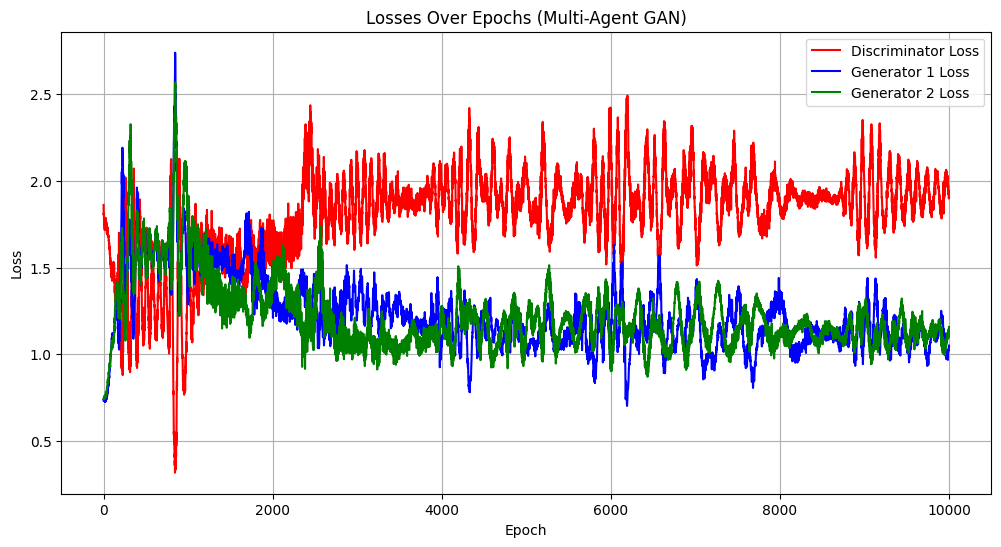

In [55]:
# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(losses_d, label='Discriminator Loss', color='red')
plt.plot(losses_g1, label='Generator 1 Loss', color='blue')
plt.plot(losses_g2, label='Generator 2 Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses Over Epochs (Multi-Agent GAN)')
plt.legend()
plt.grid(True)
plt.show()

**Note: Multi-Agent Loss Dynamics**

The loss curves for the two Generators ($G_1$ and $G_2$) show their independent, yet coupled, struggle against the Discriminator.

- **Symmetric Loss Components:** Due to the symmetric nature of the GAN's objective, the difficulty for the Discriminator to correctly classify *all* fake data is the sum of the difficulties posed by $G_1$'s output and $G_2$'s output.
- **Competition and Specialization:** The generators compete against each other to cover the real data distribution. Ideally, in a **Multi-Agent GAN**, this competition leads to specialization, where $G_1$ might focus on one cluster (mode) of the real data, and $G_2$ on the other, thereby reducing overall **mode collapse**.

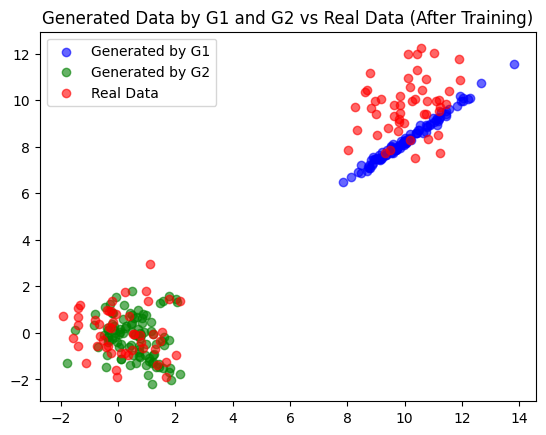

In [56]:
# Plot results
with torch.no_grad():
    noise = generate_noise(100)
    generated_data_1 = generator_1(noise).numpy()
    generated_data_2 = generator_2(noise).numpy()

plt.scatter(generated_data_1[:, 0], generated_data_1[:, 1], c='blue', label='Generated by G1', alpha=0.6)
plt.scatter(generated_data_2[:, 0], generated_data_2[:, 1], c='green', label='Generated by G2', alpha=0.6)
plt.scatter(generate_real_data(100).numpy()[:, 0], generate_real_data(100).numpy()[:, 1], c='red', label='Real Data', alpha=0.6)
plt.legend()
plt.title('Generated Data by G1 and G2 vs Real Data (After Training)')
plt.show()

## Conclusion


---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/clandolt/mlcysec_notebooks/)  If you found this tutorial helpful, please **⭐ star our repository** to show your support.   
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/clandolt/mlcysec_notebooks/issues)  For any **questions**, **typos**, or **bugs**, kindly open an issue on GitHub — we appreciate your feedback!

---